In [ ]:
!pip install plotly

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import calendar

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

import seaborn as sns

import warnings
from sklearn.utils import resample
warnings.filterwarnings('ignore')

**Introduction**


*This colab covers the Customer Segmentation using K-Means, BIRCH, GMM, DBScan and Fractral clustering based on Recency, Frequency and Monetary Analysis.*

**Background**


*E-commerce is a business method that enables people or companies to buy and sell things through the internet. E-commerce buyers come in a wide range of personalities, and a potential market is rarely defined in a single way. It's critical to understand your target market in order to ensure that your communications are both effective (attractive, action-oriented) and suitable (non-offensive, timely, and relevant). RFM analysis is a technique for segmenting client behavior. RFM analysis concentrates on 3 primary features of clients' transactions: recency, frequency, and purchase quantity, all of which are based on historical transactions. Understanding these behaviors will allow businesses to cluster different customers into groups.*



**Problem Statement**



1.   *Group customers based on their behavior so that they are divided into several segments based on RFM Analytics.*
2.   *Find out the defining characteristics in each customer segment*



**Dataset Understanding**

*The dataset contains information of 100k orders placed in numerous Brazilian markets between 2016 and 2018. This is real business information that has been anonymized. Olist, the largest department store in Brazil, has generously shared this data collection. Olist connects small businesses from all around Brazil to the channel in a simple and cost-effective manner. The merchant can sell their products on the Olist Store and have them transported straight to customers through the Olist logistics partner. The vendor will be alerted to complete the order once the buyer has purchased the product from the Olist Store.When the client receives the product or the estimated delivery date approaches, the customer receives an email with a satisfaction survey where he or she can leave a note and some remarks on the purchase experience.*

[Brazilian E-Commerce Dataset](https://www.kaggle.com/olistbr/brazilian-ecommerce)

In [ ]:
df_item = pd.read_csv("/content/olist_order_items_dataset.csv")
df_reviews = pd.read_csv("/content/olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("/content/olist_orders_dataset.csv")
df_products = pd.read_csv("/content/olist_products_dataset.csv")
df_sellers = pd.read_csv("/content/olist_sellers_dataset.csv")
df_order_pay = pd.read_csv("/content/olist_order_payments_dataset.csv")
df_customers = pd.read_csv("/content/olist_customers_dataset.csv")
df_category = pd.read_csv("/content/product_category_name_translation.csv")
df_geolocation = pd.read_csv("/content/olist_geolocation_dataset.csv")

**Data Preprocessing**

In [ ]:
df_names = ['df_item', 'df_reviews', 'df_orders', 'df_products', 'df_sellers', 'df_order_pay', 'df_customers', 'df_category', 'df_geolocation']

for names in df_names:
    print("In {} there are approximately {} null values".format(names, eval(names).isnull().sum().sum()))

In df_item there are approximately 0 null values
In df_reviews there are approximately 145903 null values
In df_orders there are approximately 4908 null values
In df_products there are approximately 2448 null values
In df_sellers there are approximately 0 null values
In df_order_pay there are approximately 0 null values
In df_customers there are approximately 0 null values
In df_category there are approximately 0 null values
In df_geolocation there are approximately 0 null values


**Order details cleanup**

In [ ]:
df_orders.isnull().sum()

# Order approval is after the customer purchases the product. So missing order_approved_at can be substituted with order_purchase_timestamp
df_orders["order_approved_at"] = df_orders["order_approved_at"].fillna(df_orders["order_purchase_timestamp"])

# Order carrier is after the order approval ie., order might be shipped on the day of confirmation. So missing order_delivered_carrier_date can be substituted with order_approved_at
df_orders["order_delivered_carrier_date"] = df_orders["order_delivered_carrier_date"].fillna(df_orders["order_approved_at"])

# Estimated delivery date is often later than actual delivery date. so missing delivery date is substituted with estimated delivery date.
df_orders["order_delivered_customer_date"] = df_orders["order_delivered_customer_date"].fillna(df_orders["order_estimated_delivery_date"])

df_orders.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

**Product details cleanup**

In [ ]:
df_products.isnull().sum()

# Product dimension or name length doesn't provide much insight so eliminating them.
df_products = df_products[~(df_products['product_name_lenght'].isnull())]
df_products = df_products[~(df_products['product_weight_g'].isnull())]

df_products.isnull().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

In [ ]:
df_reviews.isnull().sum()

# Review title is missing throughout so drop the review_comment_title column
df_reviews = df_reviews.drop(['review_comment_title'], axis = 1)

# Review comments are important going further so i'll update the null values with None
df_reviews['review_comment_message'] = df_reviews['review_comment_message'].fillna('none')

df_reviews.isnull().sum()

review_id                  0
order_id                   0
review_score               0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
dtype: int64

**Review Details cleanup**

In [ ]:
# Merging all csv into one
df = df_customers.merge(df_orders, on = 'customer_id', how = 'left')
df = df.merge(df_item, on = 'order_id', how = 'outer')
df = df.merge(df_order_pay, on = 'order_id', how = 'outer', validate='m:m')
df = df.merge(df_reviews, on = 'order_id', how = 'outer')
df = df.merge(df_products, on = 'product_id', how = 'outer')
df = df.merge(df_category, on = 'product_category_name', how = 'outer', validate='m:m')
df = df.merge(df_sellers, on = 'seller_id', how = 'outer')

In [ ]:
df.head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,88b8b52d46df026a9d1ad2136a59b30b,4.0,none,2017-05-26 00:00:00,2017-05-30 22:34:40,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577.0,itaquaquecetuba,SP
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,1.0,credit_card,1.0,275.79,7fc63200f12eebb5f387856afdd63db8,1.0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577.0,itaquaquecetuba,SP
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,2.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,1.0,credit_card,1.0,275.79,7fc63200f12eebb5f387856afdd63db8,1.0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577.0,itaquaquecetuba,SP
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:56,124.99,15.62,1.0,credit_card,7.0,140.61,251191809e37c1cffc16865947c18a4d,3.0,"Produto compatível com seu valor, muito bonito...",2017-05-27 00:00:00,2017-05-28 02:43:16,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577.0,itaquaquecetuba,SP
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,106.99,30.59,1.0,credit_card,10.0,137.58,f7123bac5b91a0e2e38d8b41fd1206f4,4.0,Entregou antes do prazo,2018-03-01 00:00:00,2018-03-02 11:11:24,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577.0,itaquaquecetuba,SP
5,fd3a0b1bd209f0e7d420c9c3d1127613,567ab47ca4deb92d46dbf54dce07d0a7,88460,angelina,SC,574fe1739f65af76badd0999db300b4f,delivered,2017-03-23 15:10:17,2017-03-23 15:25:11,2017-03-28 18:23:51,2017-04-11 10:16:56,2017-04-24 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-04-05 15:25:11,126.99,15.06,1.0,credit_card,5.0,142.05,1496c2a9c41a846ba946a98a09879660,4.0,none,2017-04-12 00:00:00,2017-04-

**Data Analysis**

In [ ]:
# Converting the delivery and purchase timestamp to date and time format using pandas
df[['order_purchase_timestamp', 'order_delivered_customer_date']]=df[['order_purchase_timestamp', 'order_delivered_customer_date']].apply(pd.to_datetime)

df['Year'] = df['order_purchase_timestamp'].dt.year

year_value = df.groupby('Year').size()
year_name = year_value.index

fig = px.pie(df["Year"], values=year_value, names=year_name, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

*Pie chart shows the the increase in sales every year from 2016 to 2018.*

In [ ]:
df['Month'] =  pd.Series(pd.Categorical(df['order_purchase_timestamp'].dt.month_name(), categories=list(calendar.month_name)[1:]))

month_values = df.groupby('Month').size()
month_names = list(calendar.month_name)[1:]

fig = px.bar(df, x=month_values, y=month_names, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

*From the above graph we can depict that the August is month which has more sales in Brazil.*

In [ ]:
df['Day'] =  pd.Series(pd.Categorical(df['order_purchase_timestamp'].dt.day_name(), categories=list(calendar.day_name)))

day_values = df.groupby('Day').size()
day_names = list(calendar.day_name)

fig = px.bar(df, x=day_values, y=day_names, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

*Monday is where most of the orders are placed by the customers.*

In [ ]:
product_name = df["product_category_name_english"].value_counts().sort_values(ascending=False)[:10]

fig = px.bar(df, x=product_name.values, y=product_name.index, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

*Bed_bath_table followed by health_beauty has the highest sales across Brazil.*

In [ ]:
df["payment_type"].replace({"not_defined": "credit_card"}, inplace=True)
df['payment_type'] = df['payment_type'].fillna("credit_card")

paymt_type = df.payment_type.unique()
values = df["payment_type"].value_counts()

fig = px.pie(df["payment_type"], values=values, names=paymt_type, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

*Almost 3/4th of the customers use credit card to buy the products, offering discount on credit card will increase sales.*

In [ ]:
state = df.customer_state.unique()
customer_count = df["customer_state"].value_counts()

fig = px.bar(df, x=customer_count, y=state, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

*Sao Paulo state has highest customer for this retail store.*

**Feature Extraction**

*Each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customer_unique_id on the dataset is to allow you to identify customers that made repurchases at the store.*

* **Monetary** : *Customer who has more contribution towards revenue.*

In [ ]:
df['total_payment'] = df['payment_value'] * df['payment_installments']

#get the payment amount per customer
df_monetary = df.groupby('customer_unique_id')['total_payment'].sum()
df_monetary = df_monetary.reset_index()

# generate revenue column ie., monetary for each customer
df_monetary.columns = ['customer_unique_id', 'monetary']

fig = px.histogram(df_monetary, x = 'monetary', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [ ]:
print(df_monetary['monetary'].describe())

count     96096.000000
mean        882.248653
std        3394.450208
min           0.000000
25%          82.730000
50%         206.995000
75%         642.330000
max      345624.000000
Name: monetary, dtype: float64


* **Frequency** : *Total number of orders for each customer*

In [ ]:
#get the number of orders per customer
df_frequency = df.groupby('customer_unique_id')['order_id'].count()
df_frequency = df_frequency.reset_index()

#generate frequency column for each customer
df_frequency.columns = ['customer_unique_id', 'frequency']

fig = px.histogram(df_frequency, x = 'frequency', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [ ]:
print(df_frequency['frequency'].describe())

count    96096.000000
mean         1.239833
std          0.853158
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         75.000000
Name: frequency, dtype: float64


* **Recency** : *Most recent date of purchase and inactive period*

In [ ]:
#get the max purchase date for each customer and create a dataframe with it
df_recency = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_recency.columns = ['customer_unique_id','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
df_recency['recency'] = (df_recency['MaxPurchaseDate'].max() - df_recency['MaxPurchaseDate']).dt.days

fig = px.histogram(df_recency, x = 'recency', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

In [ ]:
print(df_recency['recency'].describe())

count    96096.000000
mean       287.735691
std        153.414676
min          0.000000
25%        163.000000
50%        268.000000
75%        397.000000
max        772.000000
Name: recency, dtype: float64


In [ ]:
mfr_df = pd.merge(df_monetary, df_frequency, on='customer_unique_id', how='inner')
mfr_df = pd.merge(mfr_df, df_recency, on='customer_unique_id', how='inner')

mfr_df = mfr_df.drop('MaxPurchaseDate', axis = 1)

In [ ]:
mfr_df.head(10)

,customer_unique_id,monetary,frequency,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163
2,0000f46a3911fa3c0805444483337064,689.76,1,585
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336
5,0004bd2a26a76fe21f786e4fbd80607f,1335.84,1,194
6,00050ab1314c0e55a6ca13cf7181fecf,35.38,1,180
7,00053a61a98854899e70ed204dd4bafe,2515.08,2,231
8,0005e1862207bf6ccc02e4228effd9a0,450.36,1,591
9,0005ef4cd20d2893f0d9fbd94d3c0d97,519.04,1,219


**Feature Scaling**

In [ ]:
from sklearn.preprocessing import StandardScaler

features = mfr_df[['monetary', 'frequency', 'recency']]
col_names = ['monetary_scaled', 'recency_scaled','frequency_scaled']
scaler = StandardScaler().fit(features.values)
scaled_features = scaler.transform(features.values)
mfr_df[col_names] = scaled_features

In [ ]:
mfr_df.head(10)

,customer_unique_id,monetary,frequency,recency,monetary_scaled,recency_scaled,frequency_scaled
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160,0.074519,-0.281113,-0.832621
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163,-0.251900,-0.281113,-0.813067
2,0000f46a3911fa3c0805444483337064,689.76,1,585,-0.056707,-0.281113,1.937662
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369,-0.208509,-0.281113,0.529706
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336,0.088112,-0.281113,0.314602
5,0004bd2a26a76fe21f786e4fbd80607f,1335.84,1,194,0.133628,-0.281113,-0.610999
6,00050ab1314c0e55a6ca13cf7181fecf,35.38,1,180,-0.249488,-0.281113,-0.702255
7,00053a61a98854899e70ed204dd4bafe,2515.08,2,231,0.481032,0.891008,-0.369821
8,0005e1862207bf6ccc02e4228effd9a0,450.36,1,591,-0.127234,-0.281113,1.976772
9,0005ef4cd20d2893f0d9fbd94d3c0d97,519.04,1,219,-0.107001,-0.281113,-0.448041


**silhouette Score**

In [ ]:
features_used = mfr_df[['monetary_scaled', 'recency_scaled','frequency_scaled']]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Silhouette score')

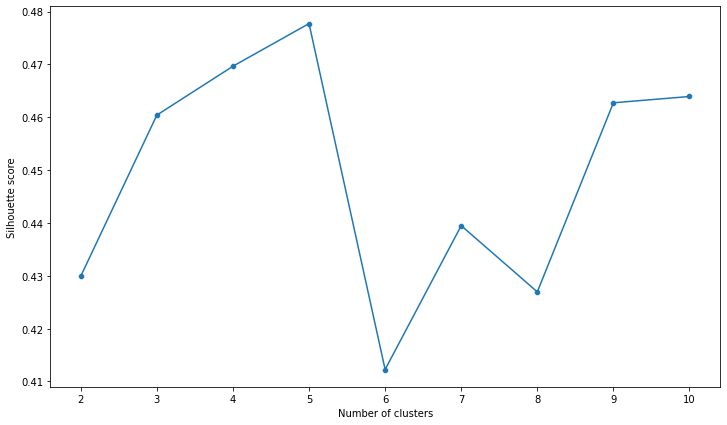

In [ ]:
# Calculating the Sillhoutte Score
silhouette_scores = []
number_of_cluster = range(2, 11)

for i in number_of_cluster:
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(features_used)

  labels = kmeans.labels_
  silhouette_scores.append(silhouette_score(features_used, labels, metric = 'euclidean', random_state=0))


# Plotting the Sillhoutte Score
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster, silhouette_scores)
sns.scatterplot(number_of_cluster, silhouette_scores)

plt.xticks(number_of_cluster)

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

**Clustering customers based on objective functions**

### **K-Means Clustering**

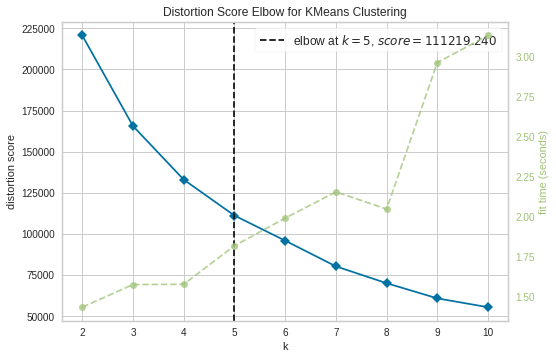

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,11))
 
visualizer.fit(features_used)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(features_used)

KMeans(n_clusters=5)

In [ ]:
mfr_df['k_means_clust'] = kmeans.predict(features_used)
mfr_df

,customer_unique_id,monetary,frequency,recency,monetary_scaled,recency_scaled,frequency_scaled,k_means_clust
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160,0.074519,-0.281113,-0.832621,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163,-0.251900,-0.281113,-0.813067,1
2,0000f46a3911fa3c0805444483337064,689.76,1,585,-0.056707,-0.281113,1.937662,2
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369,-0.208509,-0.281113,0.529706,2
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336,0.088112,-0.281113,0.314602,2
...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,41348.40,2,495,11.921330,0.891008,1.351014,4
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,310,-0.234993,-0.281113,0.145126,2
96093,ffff371b4d645b6ecea244b27531430a,112.46,1,617,-0.226780,-0.281113,2.146249,2
96094,ffff5962728ec6157033ef9805bacc48,668.45,1,168,-0.062985,-0.281113,-0.780475,1


In [ ]:
# Distributions Clusters
mfr_df['k_means_clust'].value_counts()

1    52783
2    38994
0     3621
4      678
3       20
Name: k_means_clust, dtype: int64

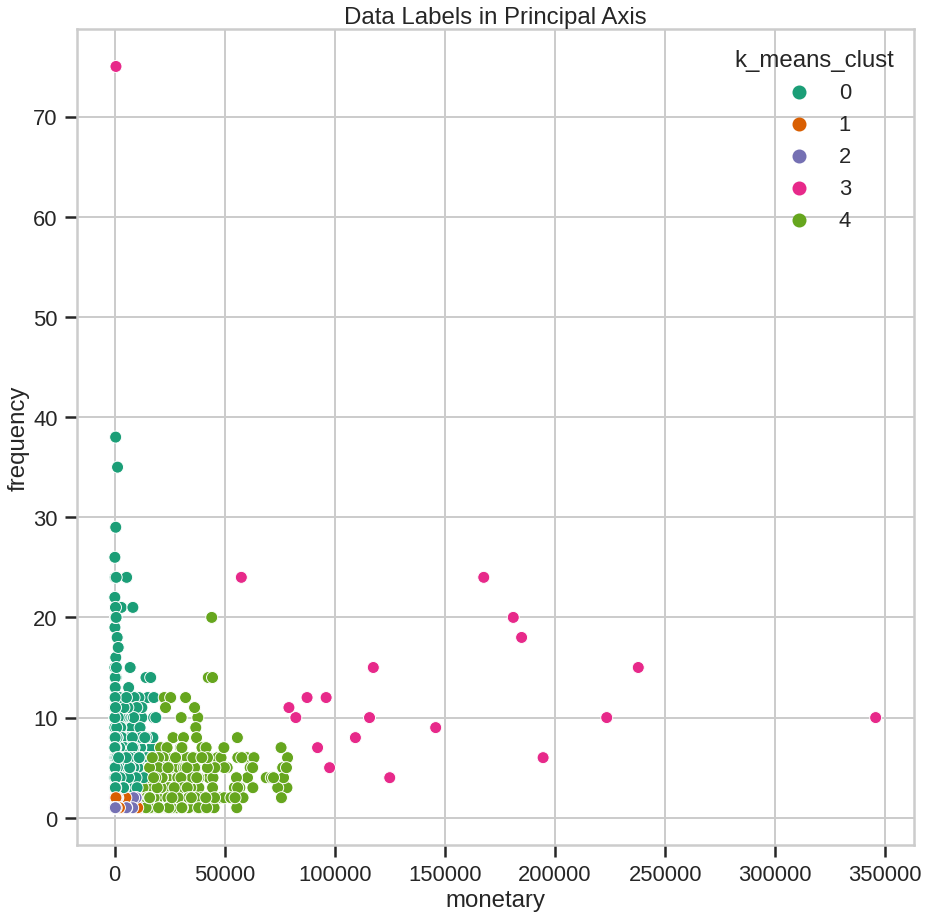

In [ ]:
sns.set_context('poster')
plt.figure(figsize=(15,15))
sns.scatterplot(x=mfr_df['monetary'],y=mfr_df['frequency'],hue=mfr_df['k_means_clust'], palette='Dark2')
plt.title('Data Labels in Principal Axis')
plt.show()

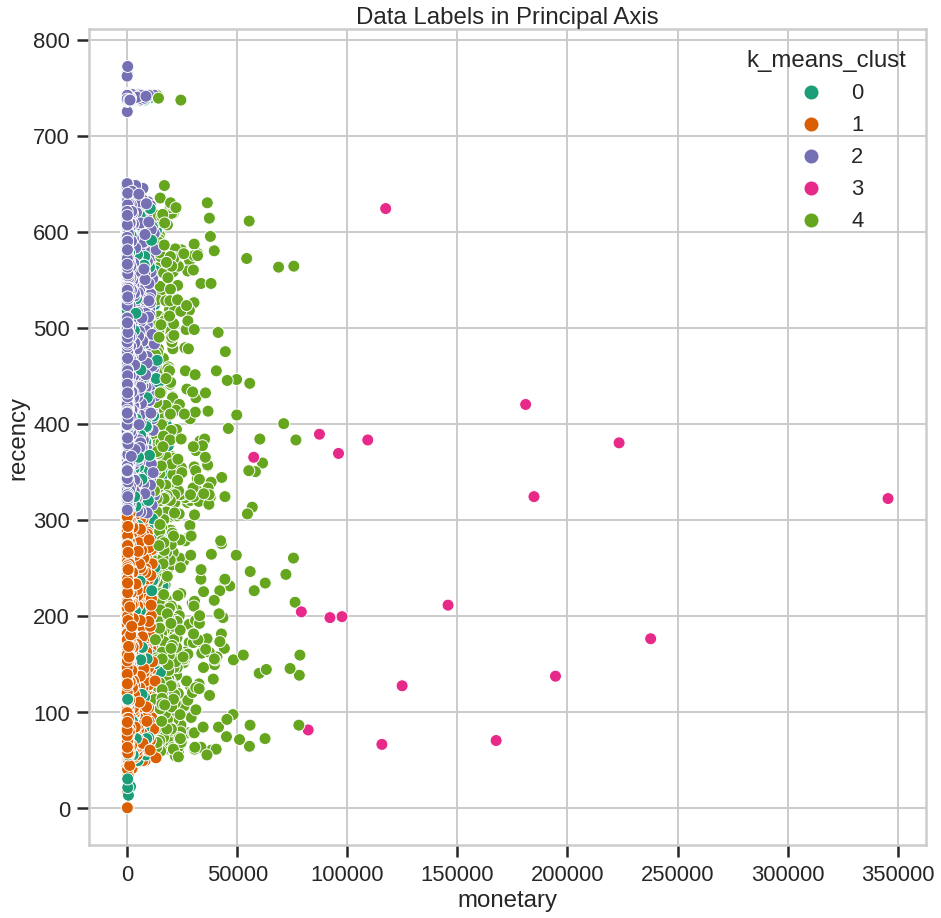

In [ ]:
sns.set_context('poster')
plt.figure(figsize=(15,15))
sns.scatterplot(x=mfr_df['monetary'],y=mfr_df['recency'],hue=mfr_df['k_means_clust'], palette='Dark2')
plt.title('Data Labels in Principal Axis')
plt.show()

*Following are the analysis as per the above visualization.*

*   **Cluster 0 : Regular Customers**

    * *Give bonus on the payment type they use and exchanging that points with vouchers.*
    * *Give voucher if they high value products. This voucher should be used to buy other products.*
    * *Introducing a benefit for a loyal customers.*
    
*   **Cluster 2 : Occation Customers**

    * *Adding a customers point that can be traded for voucher. This will help customer retain and make more purchase in order to use the voucher.*
    * *Adding events that provides points to the customers, so that they often visit the website.*

*   **Cluster 1 : Passive Customers**

    * *Give awareness of all the products. This can make customers buy from other product categories.*
    * *Give discounts based on payment methods. This will help to increase buying frequency.*

*   **Cluster 3 : Valuable Customers**
    * *Give promo for events such as blackfriday or Big day sale. This can have discount on products that they usually buy.*
    * *Give voucher if they high value products. This voucher should be used to buy other products.*
    
*   **Cluster 4 : Loyal Customers**

    * *Give reward for customers. The reward is to give discount on high value products.*
    * *Give promo for events such as blackfriday or Big day sale. This can have discount on products that they usually buy.*


### **BIRCH Clustering**

Text(0, 0.5, 'Silhouette score')

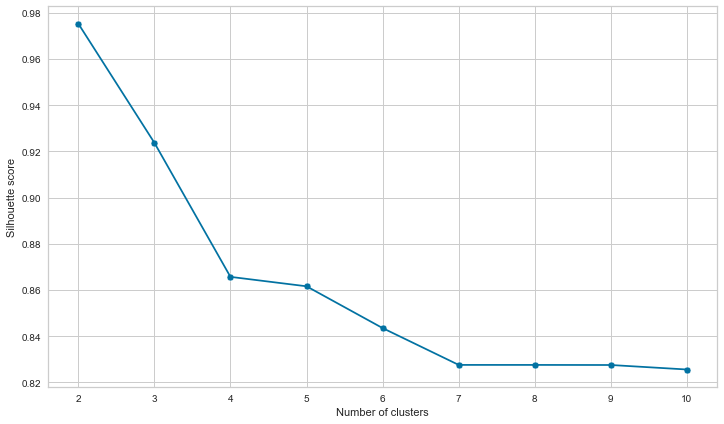

In [ ]:
# Calculating the Sillhoutte Score
silhouette_scores = []
number_of_cluster = range(2, 11)

for i in number_of_cluster:
  birch = Birch(n_clusters=i)
  birch.fit(features_used)

  labels = birch.labels_
  silhouette_scores.append(silhouette_score(features_used, labels, metric = 'euclidean', random_state=0))


# Plotting the Sillhoutte Score
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster, silhouette_scores)
sns.scatterplot(number_of_cluster, silhouette_scores)

plt.xticks(number_of_cluster)

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

In [ ]:
brc = Birch(n_clusters=2)
brc.fit(features_used)

mfr_df['brc_clust'] = brc.predict(features_used)
mfr_df

,customer_unique_id,monetary,frequency,recency,monetary_scaled,recency_scaled,frequency_scaled,brc_clust
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160,0.074519,-0.281113,-0.832621,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163,-0.251900,-0.281113,-0.813067,0
2,0000f46a3911fa3c0805444483337064,689.76,1,585,-0.056707,-0.281113,1.937662,0
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369,-0.208509,-0.281113,0.529706,0
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336,0.088112,-0.281113,0.314602,0
...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,41348.40,2,495,11.921330,0.891008,1.351014,0
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,310,-0.234993,-0.281113,0.145126,0
96093,ffff371b4d645b6ecea244b27531430a,112.46,1,617,-0.226780,-0.281113,2.146249,0
96094,ffff5962728ec6157033ef9805bacc48,668.45,1,168,-0.062985,-0.281113,-0.780475,0


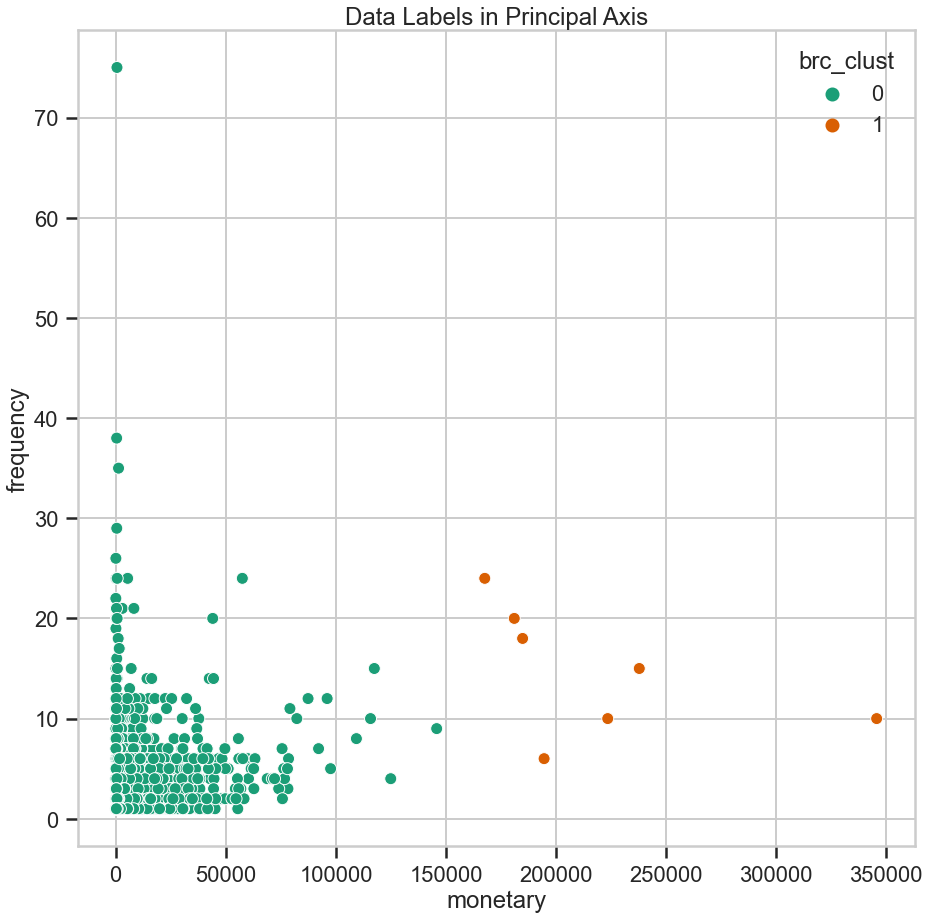

In [ ]:
sns.set_context('poster')
plt.figure(figsize=(15,15))
sns.scatterplot(x=mfr_df['monetary'],y=mfr_df['frequency'],hue=mfr_df['brc_clust'], palette='Dark2')
plt.title('Data Labels in Principal Axis')
plt.show()

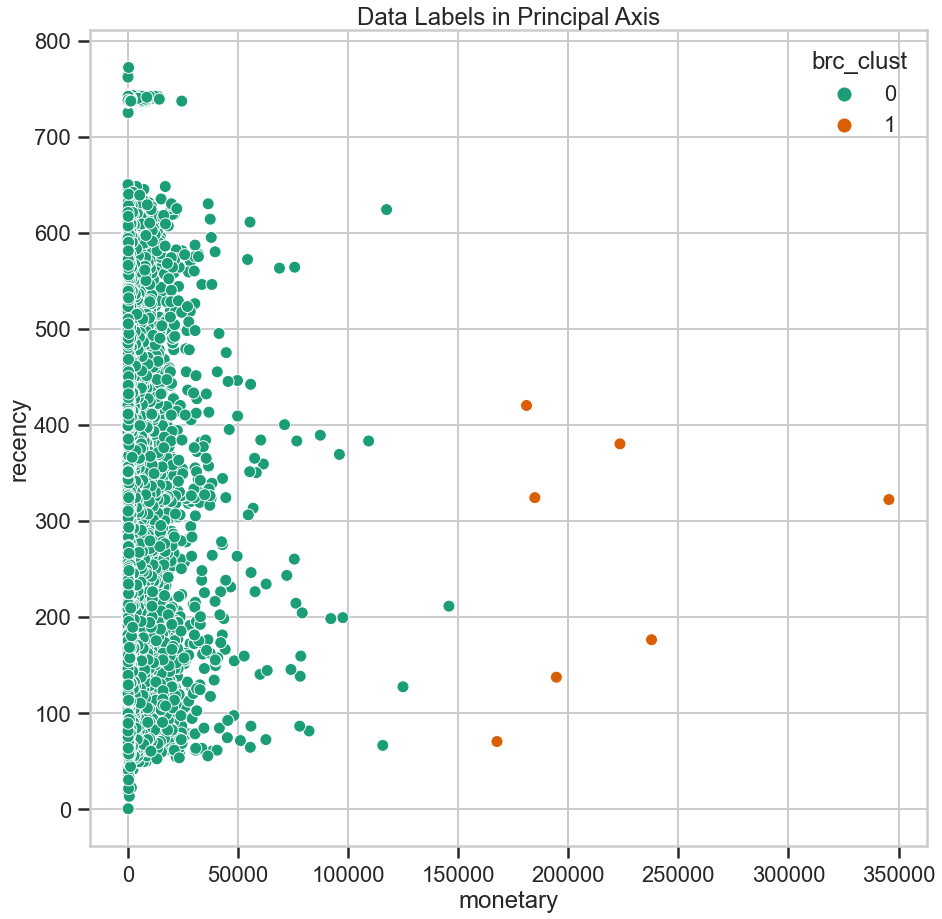

In [ ]:
sns.set_context('poster')
plt.figure(figsize=(15,15))
sns.scatterplot(x=mfr_df['monetary'],y=mfr_df['recency'],hue=mfr_df['brc_clust'], palette='Dark2')
plt.title('Data Labels in Principal Axis')
plt.show()

In [ ]:
mfr_df

,customer_unique_id,monetary,frequency,recency,monetary_scaled,recency_scaled,frequency_scaled,brc_clust
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160,0.074519,-0.281113,-0.832621,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163,-0.251900,-0.281113,-0.813067,0
2,0000f46a3911fa3c0805444483337064,689.76,1,585,-0.056707,-0.281113,1.937662,0
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369,-0.208509,-0.281113,0.529706,0
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336,0.088112,-0.281113,0.314602,0
...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,41348.40,2,495,11.921330,0.891008,1.351014,0
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,310,-0.234993,-0.281113,0.145126,0
96093,ffff371b4d645b6ecea244b27531430a,112.46,1,617,-0.226780,-0.281113,2.146249,0
96094,ffff5962728ec6157033ef9805bacc48,668.45,1,168,-0.062985,-0.281113,-0.780475,0


* **Cluster 0 : Mid-value customers** 
    * It includes all the customers with different recency and frequency but who doesn't purchase high value items.

* **Cluster 1 : High-Value customers**
    * It includes customers who provides high revenue to the retail store.





## **GMM Clustering**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Silhouette score')

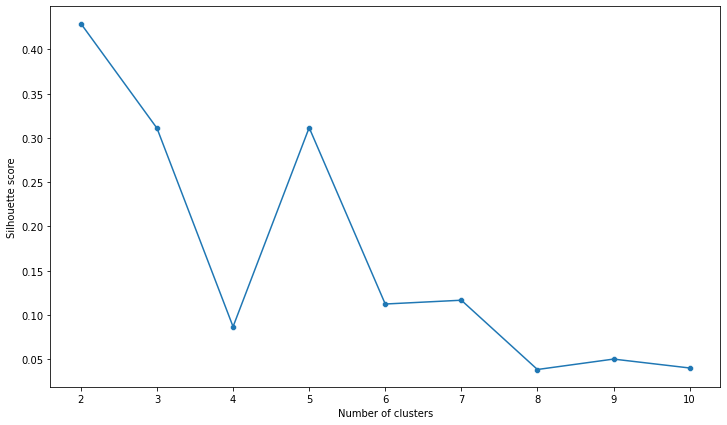

In [ ]:
# Calculating the Sillhoutte Score
silhouette_scores = []
number_of_cluster = range(2, 11)

for i in number_of_cluster:
  gm = GaussianMixture(n_components=i, random_state=0)
  gm.fit(features_used)

  labels = gm.predict(features_used)
  silhouette_scores.append(silhouette_score(features_used, labels, metric = 'euclidean', random_state=0))


# Plotting the Sillhoutte Score
plt.figure(figsize=(12,7))

sns.lineplot(number_of_cluster, silhouette_scores)
sns.scatterplot(number_of_cluster, silhouette_scores)

plt.xticks(number_of_cluster)

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

In [ ]:
gmm = GaussianMixture(n_components=2)
gmm.fit(features_used)

mfr_df['gmm_clust'] = gmm.predict(features_used)

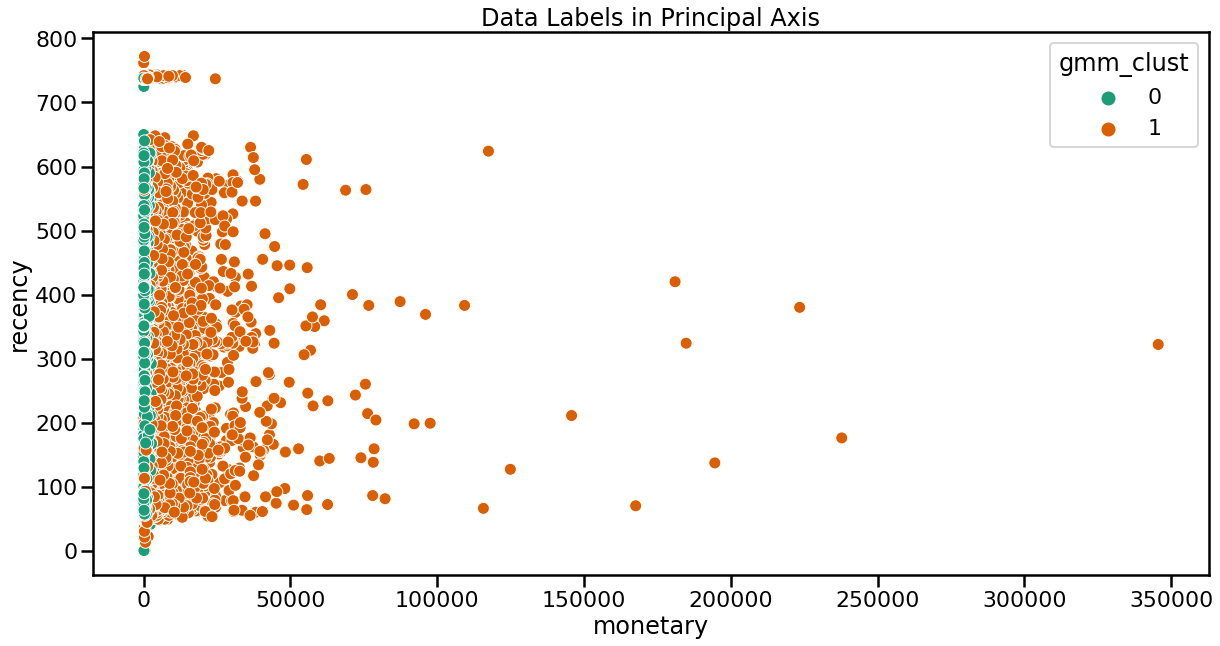

In [ ]:
sns.set_context('poster')
plt.figure(figsize=(20,10))
sns.scatterplot(x=mfr_df['monetary'],y=mfr_df['recency'],hue=mfr_df['gmm_clust'], palette='Dark2')
plt.title('Data Labels in Principal Axis')
plt.show()

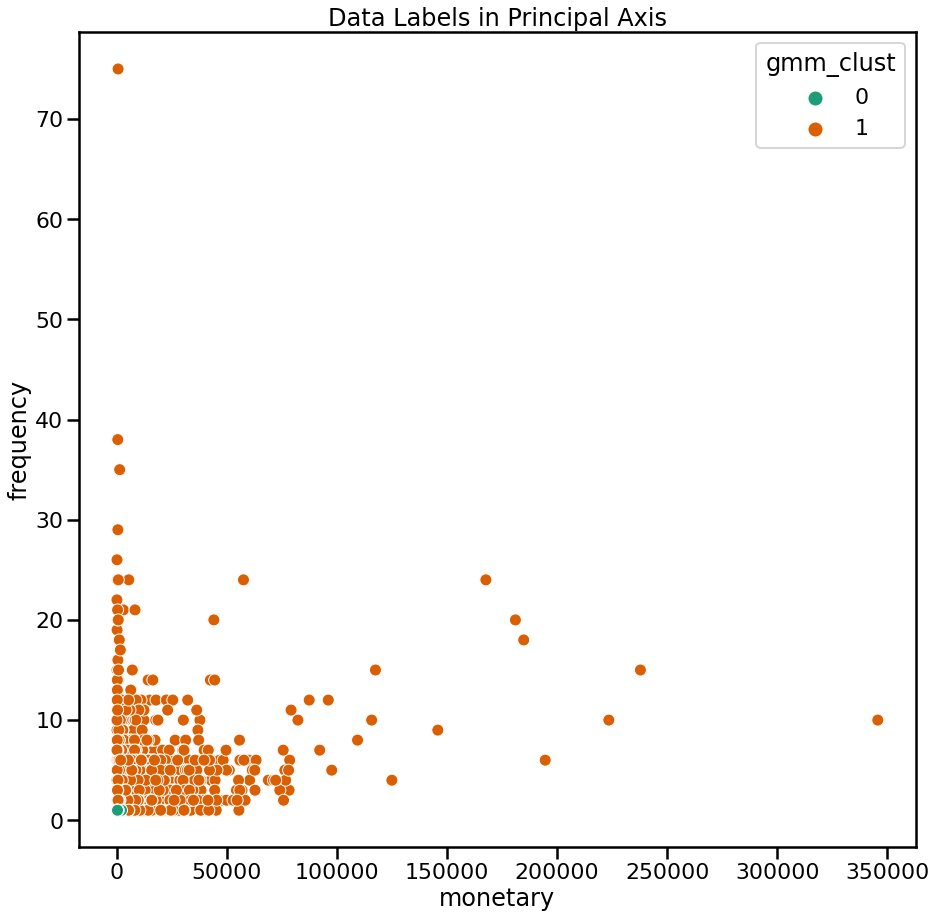

In [ ]:
sns.set_context('poster')
plt.figure(figsize=(15,15))
sns.scatterplot(x=mfr_df['monetary'],y=mfr_df['frequency'],hue=mfr_df['gmm_clust'], palette='Dark2')
plt.title('Data Labels in Principal Axis')
plt.show()

* **Cluster 0 : Low-value customers**
    * Most Recent and old customers with less revenue are grouped into this cluster.

* **Cluster 0 : Low-value/ High-value customers**
    * Customers from mid revenue to large revenue are grouped into this cluster.

## **DBScan Clustering**

In [ ]:
for eps in [i/10 for i in range(4,9)]:
  for min_samples in range(4,9):
    print("\neps={}".format(eps))
    print("min_samples={}".format(min_samples))
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(features_used)
    silh = silhouette_score(features_used, labels)
    print("Clusters present: {}".format(np.unique(labels)))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))
    print("Silhouette Score: {}".format(silh))


eps=0.4
min_samples=4
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31]
Cluster sizes: [  482 81287 10465   900   265  1977   282   245     9     6    27     5
    16     7     9     8     5     4     5     4    30     4     6     4
     4     4     6     6     6     4     4     4     6]
Silhouette Score: 0.2645068615962947

eps=0.4
min_samples=5
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27]
Cluster sizes: [  548 81276 10455   900   260  1976   276    10   226     5    27     5
     9     5     5    12    30    13     5     5     7     6     5     5
     5     5     5     4     6]
Silhouette Score: 0.2611318370987622

eps=0.4
min_samples=6
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Cluster sizes: [  641 81251 10451   895   260  1973   257    10   218    24    25     6
     6    30    11     5     7     7     8     5

In [ ]:
#0.7 8
dbscan = DBSCAN(eps = 0.7, min_samples=8)
mfr_df['db_clust'] = dbscan.fit_predict(features_used)

In [ ]:
mfr_df

,customer_unique_id,monetary,frequency,recency,monetary_scaled,recency_scaled,frequency_scaled,db_clust
0,0000366f3b9a7992bf8c76cfdf3221e2,1135.20,1,160,0.074519,-0.281113,-0.832621,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,163,-0.251900,-0.281113,-0.813067,0
2,0000f46a3911fa3c0805444483337064,689.76,1,585,-0.056707,-0.281113,1.937662,0
3,0000f6ccb0745a6a4b88665a16c9f078,174.48,1,369,-0.208509,-0.281113,0.529706,0
4,0004aac84e0df4da2b147fca70cf8255,1181.34,1,336,0.088112,-0.281113,0.314602,0
...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,41348.40,2,495,11.921330,0.891008,1.351014,-1
96092,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,310,-0.234993,-0.281113,0.145126,0
96093,ffff371b4d645b6ecea244b27531430a,112.46,1,617,-0.226780,-0.281113,2.146249,0
96094,ffff5962728ec6157033ef9805bacc48,668.45,1,168,-0.062985,-0.281113,-0.780475,0


In [ ]:
mfr_df['db_clust'].value_counts()

 0     81565
 1     10510
 3      2017
 2       920
-1       409
 4       304
 5       256
 8        43
 6        29
 7        15
 10       11
 11        9
 9         8
Name: db_clust, dtype: int64

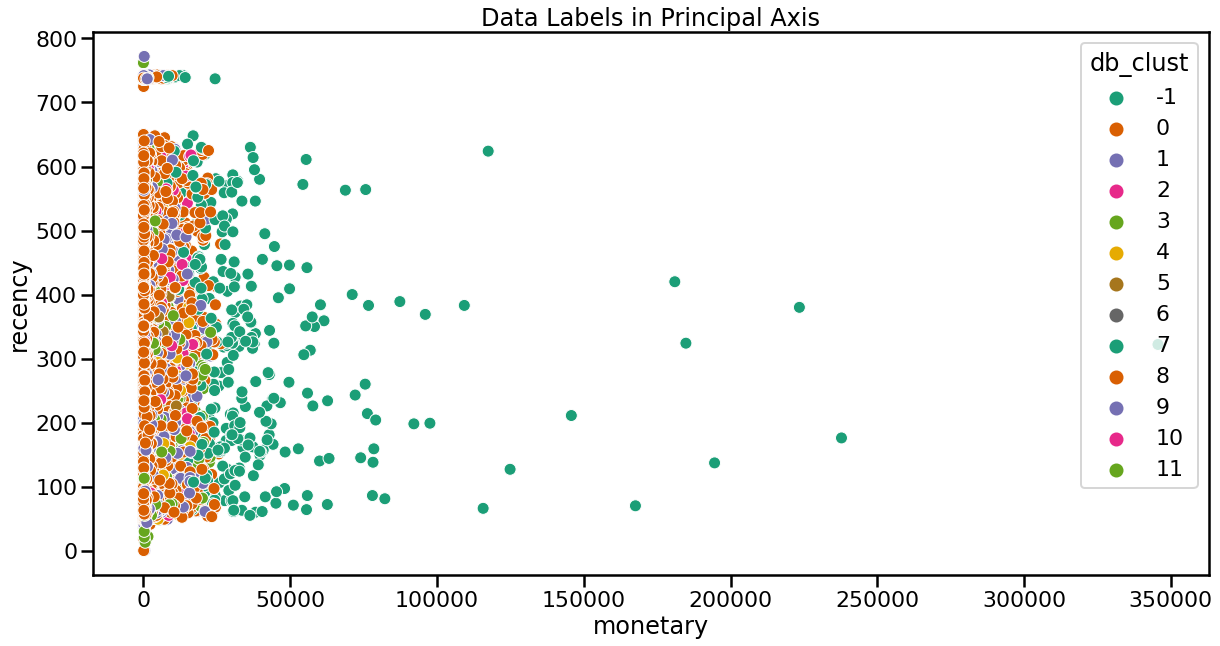

In [ ]:
sns.set_context('poster')
plt.figure(figsize=(20,10))
sns.scatterplot(x=mfr_df['monetary'],y=mfr_df['recency'],hue=mfr_df['db_clust'], palette='Dark2')
plt.title('Data Labels in Principal Axis')
plt.show()

*DBSCAN clusters data into many groups, which is difficult to get the insight and segment the customers*

**When compared to K-means, BIRCH, GMM and DBScan. K-means provides a insight on which customers can be segmented.**